## Calculate the TWA transport tensor

Here we take the time averaged TWA fields (means and eddy fluxes) and estimate the corresponding transport tensor. 

Here we use a coarsening scale of 50km since it worked well with the Z-averaged fields. 

In [1]:
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt

import xgcm 
%matplotlib inline

import numpy as np
from xgcm import Grid
from scipy.linalg import pinv, eig
from numpy.linalg import eigh

In [2]:
# load the grid for taking horizontal gradients
ds = xr.open_zarr('/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored_zarr/')
grid = Grid(ds, periodic='X')

In [3]:
ds_hat = xr.open_dataset('analysis_data_files/ds_hat_800.nc')

# these eddy fluxes were saved as uppcpp 
ds_eddy_u = xr.open_dataset('analysis_data_files/ds_twa_eddy_u_800.nc')
ds_eddy_v = xr.open_dataset('analysis_data_files/ds_twa_eddy_v_800.nc')

In [4]:
# the x and y gradients of hat mean
ds_hat_grads = xr.Dataset()
 
dx = 5e3

for var_name in ds_hat.keys():
    if (var_name != 'U' and var_name != 'V'):
        ds_hat_grads['d'+var_name+'dx'] = grid.interp(grid.diff(ds_hat[var_name], 'X')/dx, 'X')
        
        ds_hat_grads['d'+var_name+'dy'] = grid.interp(grid.diff(ds_hat[var_name], 'Y', boundary='extend')/dx,
                                                      'Y', boundary='extend')
        

In [5]:
# copied and modified from funcs.py
def get_flux_arrays_2D(ds_u, ds_v, list_tracers): 
    # U''C''
    testxr1 = ds_u['U_'+'PTRACER01']
    testxr1['tracer_num'] = 1

    UppCpp = testxr1 

    n=2
    for i in list_tracers[1:]: 
        temp = ds_u['U_'+i]
        temp['tracer_num'] = n 
        n=n+1

        UppCpp = xr.concat([UppCpp, temp], dim='tracer_num')

    UppCpp.name = 'UppCpp'
    
    # V''C''
    testxr1 = ds_v['V_'+'PTRACER01']
    testxr1['tracer_num'] = 1

    VppCpp = testxr1 

    n=2
    for i in list_tracers[1:]: 
        temp = ds_v['V_'+i]
        temp['tracer_num'] = n 
        n=n+1

        VppCpp = xr.concat([VppCpp, temp], dim='tracer_num')

    VppCpp.name = 'VppCpp'
    
    return [UppCpp, VppCpp]

In [6]:
list_tracers = ['PTRACER01', 'PTRACER02', 'PTRACER03', 'PTRACER04', 'PTRACER05',
               'PTRACER06', 'PTRACER07', 'PTRACER08', 'PTRACER09', 'PTRACER10',
               'PTRACER11', 'PTRACER12', 'PTRACER13', 'PTRACER14', 'PTRACER15',
               'PTRACER16', 'PTRACER17', 'PTRACER18', 'PTRACER19', 'PTRACER20']

In [7]:
[UppCpp, VppCpp] = get_flux_arrays_2D(ds_eddy_u, ds_eddy_v, list_tracers)

In [8]:
def get_grad_arrays_2D(ds, list_tracers): 
    # Put tracer gradients into xarrays
    
    # dCdx
    testxr1 = ds['dPTRACER01dx']
    testxr1['tracer_num'] = 1

    dCdx = testxr1 

    n=2
    for i in list_tracers[1:]: 
        temp = ds['d'+i+'dx']
        temp['tracer_num'] = n 
        n=n+1

        dCdx = xr.concat([dCdx, temp], dim='tracer_num')   
    dCdx.name = 'dCdx'
    
    # dCdy
    testxr1 = ds['dPTRACER01dy']
    testxr1['tracer_num'] = 1

    dCdy = testxr1 

    n=2
    for i in list_tracers[1:]: 
        temp = ds['d'+i+'dy']
        temp['tracer_num'] = n 
        n=n+1

        dCdy = xr.concat([dCdy, temp], dim='tracer_num')
    dCdy.name = 'dCdy'
    
    return [dCdx, dCdy]

In [9]:
[dCdx, dCdy]= get_grad_arrays_2D(ds_hat_grads, list_tracers)

In [10]:
# coarsen fields 
npts = int(50e3/dx)
UppCpp_coarse = UppCpp.coarsen(XC=npts, YC=npts).mean().rename('UppCpp')
VppCpp_coarse = VppCpp.coarsen(XC=npts, YC=npts).mean().rename('VppCpp')
dCdx_coarse = dCdx.coarsen(XC=npts, YC=npts).mean().rename('dCdx')
dCdy_coarse = dCdy.coarsen(XC=npts, YC=npts).mean().rename('dCdy')

In [11]:
UppCpp_coarse.to_netcdf('analysis_data_files/UppCpp_TWA_50km_av800.nc')
VppCpp_coarse.to_netcdf('analysis_data_files/VppCpp_TWA_50km_av800.nc')
dCdx_coarse.to_netcdf('analysis_data_files/dCdx_TWA_50km_av800.nc')
dCdy_coarse.to_netcdf('analysis_data_files/dCdy_TWA_50km_av800.nc')

In [12]:
def calc_tensor_2D(uc,vc, cx,cy):
    Aflux = np.array([uc, vc])
    Agrad = np.array([cx, cy])

    if ~(np.isnan(Agrad).any() | np.isnan(Aflux).any()):
        return -(Aflux.dot(pinv(Agrad)))
    else:
        return np.nan*(Aflux.dot(Agrad.T))  

### Explore the shapes of the matrices 

In [31]:
UppCpp_coarse

<xarray.DataArray 'UppCpp' (tracer_num: 20, YC: 40, XC: 40, T: 101)>
array([[[[ 2.94761103e-04, -2.10566243e-04, -8.93863360e-04, ...,
                      nan,             nan,             nan],
         [ 2.44298574e-04,  3.17796510e-05, -8.98084960e-04, ...,
                      nan,             nan,             nan],
         [-5.33747532e-05, -2.05024506e-04, -9.19738808e-04, ...,
                      nan,             nan,             nan],
         ...,
         [ 3.28605788e-05, -2.43318327e-05, -5.41588887e-04, ...,
                      nan,             nan,             nan],
         [ 3.10750341e-05,  5.44947618e-06, -7.03996688e-04, ...,
                      nan,             nan,             nan],
         [ 1.18691015e-04, -2.39048676e-04, -7.86686704e-04, ...,
                      nan,             nan,             nan]],

        [[ 8.58619844e-07, -4.98027943e-07, -4.64488935e-05, ...,
                      nan,             nan,             nan],
         [-3.54658114e-06,  1.29430718e-05, -1.74275047e-04, ...,
                      nan,             nan,             nan],
         [-1.76783528e-04, -2.06191205e-04, -2.28600460e-04, ...,
                      nan,             nan,             nan],
...
         [ 2.64332117e-04,  4.59845975e-04,  6.43164662e-04, ...,
                      nan,             nan,             nan],
         [ 2.54832501e-04,  3.99147602e-04,  5.43924700e-04, ...,
                      nan,             nan,             nan],
         [ 8.45486656e-05,  1.75699035e-04,  3.51401511e-04, ...,
                      nan,             nan,             nan]],

        [[-8.16658822e-04, -4.17651711e-05,  7.13774447e-04, ...,
          -1.85012414e-04,             nan,             nan],
         [-5.02872764e-04,  6.09033030e-05,  6.52094432e-04, ...,
          -1.42498239e-04,             nan,             nan],
         [-2.75999470e-04,  1.40204237e-04,  5.94718498e-04, ...,
          -1.44931039e-04,             nan,             nan],
         ...,
         [-1.12471707e-03,  4.70259076e-04,  1.87012453e-03, ...,
          -1.22542429e-04,             nan,             nan],
         [-1.04500022e-03,  2.87910644e-04,  1.49750127e-03, ...,
          -1.60347113e-04,             nan,             nan],
         [-1.00521391e-03,  6.97291358e-05,  1.04923687e-03, ...,
          -1.77738767e-04,             nan,             nan]]]])
Coordinates:
    Depth       (YC, XC) float32 2.686e+03 2.686e+03 ... 2.985e+03 2.985e+03
  * XC          (XC) float32 2.5e+04 7.5e+04 1.25e+05 ... 1.925e+06 1.975e+06
  * YC          (YC) float32 2.5e+04 7.5e+04 1.25e+05 ... 1.925e+06 1.975e+06
    rA          (YC, XC) float32 2.5e+07 2.5e+07 2.5e+07 ... 2.5e+07 2.5e+07
  * T           (T) float64 0.0 0.08 0.16 0.24 0.32 ... 7.68 7.76 7.84 7.92 8.0
  * tracer_num  (tracer_num) int64 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20

In [26]:
Aflux = np.array([UppCpp_coarse.sel(XC=500e3, YC=1000e3, T=1, method='nearest').sel(tracer_num=slice(2,20,2)).values, 
                  VppCpp_coarse.sel(XC=500e3, YC=1000e3, T=1, method='nearest').sel(tracer_num=slice(2,20,2)).values])

Aflux.shape

(2, 10)

In [27]:
Agrad = np.array([dCdx_coarse.sel(XC=500e3, YC=1000e3, T=1, method='nearest').sel(tracer_num=slice(2,20,2)).values, 
                  dCdy_coarse.sel(XC=500e3, YC=1000e3, T=1, method='nearest').sel(tracer_num=slice(2,20,2)).values])

Agrad.shape

(2, 10)

In [32]:
K = -(Aflux.dot(pinv(Agrad)))
K

array([[3616.58024164, -931.41614418],
       [ 517.44169992, 2370.16534099]])

### Actually compute the tensor

In [12]:
%%time
Ktensor_fast = xr.apply_ufunc(calc_tensor_2D, 
                       UppCpp_coarse.sel(tracer_num=slice(1,19,2)),
                       VppCpp_coarse.sel(tracer_num=slice(1,19,2)),
                       dCdx_coarse.sel(tracer_num=slice(1,19,2)),
                       dCdy_coarse.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':2,'j':2})
Ktensor_fast.load();

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:8: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 14.7 s, sys: 55.9 ms, total: 14.8 s
Wall time: 14.8 s


<xarray.DataArray (YC: 40, XC: 40, T: 101, i: 2, j: 2)>
array([[[[[ 1.37635315e+03,  5.24337097e+02],
          [-1.95205475e+02, -1.23242081e+02]],

         [[ 1.79754956e+03,  5.40568298e+02],
          [-3.91119690e+02, -1.15118225e+02]],

         [[ 1.62559583e+03, -1.10842871e+03],
          [ 3.20557770e+02,  7.74163132e+01]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],

...

        [[[ 6.53906689e+03,  5.24078186e+02],
          [ 1.72201141e+02,  2.62735016e+02]],

         [[ 6.85649170e+03,  5.09479431e+02],
          [ 9.38944931e+01,  2.41696686e+02]],

         [[ 7.23608838e+03,  4.83792191e+01],
          [ 1.98243088e+02,  2.14776688e+02]],

         ...,

         [[ 7.97267529e+03,  2.57471985e+02],
          [ 5.91349077e+00,  2.15487289e+01]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]]]], dtype=float32)
Coordinates:
    Depth    (YC, XC) float32 2.686e+03 2.686e+03 ... 2.985e+03 2.985e+03
  * XC       (XC) float32 2.5e+04 7.5e+04 1.25e+05 ... 1.925e+06 1.975e+06
  * YC       (YC) float32 2.5e+04 7.5e+04 1.25e+05 ... 1.925e+06 1.975e+06
    rA       (YC, XC) float32 2.5e+07 2.5e+07 2.5e+07 ... 2.5e+07 2.5e+07
  * T        (T) float64 0.0 0.08 0.16 0.24 0.32 0.4 ... 7.68 7.76 7.84 7.92 8.0
Dimensions without coordinates: i, j

In [13]:
%%time
Ktensor_slow = xr.apply_ufunc(calc_tensor_2D, 
                       UppCpp_coarse.sel(tracer_num=slice(2,20,2)),
                       VppCpp_coarse.sel(tracer_num=slice(2,20,2)),
                       dCdx_coarse.sel(tracer_num=slice(2,20,2)),
                       dCdy_coarse.sel(tracer_num=slice(2,20,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':2,'j':2})

Ktensor_slow.load();

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:8: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 15.4 s, sys: 42.7 ms, total: 15.4 s
Wall time: 15.4 s


<xarray.DataArray (YC: 40, XC: 40, T: 101, i: 2, j: 2)>
array([[[[[ 7.26821167e+02,  2.05221985e+02],
          [ 1.54393320e+01, -5.24006538e+01]],

         [[ 1.49782874e+03,  3.54733704e+02],
          [-2.74265747e+02, -6.54174652e+01]],

         [[ 2.12980127e+03, -1.06041162e+03],
          [ 4.92845612e+02,  7.62984390e+01]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],

...

        [[[ 7.55961426e+03,  3.26748749e+02],
          [ 2.03047195e+02,  2.75794617e+02]],

         [[ 7.89198389e+03,  3.62096893e+02],
          [ 1.31139008e+02,  2.60051300e+02]],

         [[ 8.30317383e+03,  4.46282005e+01],
          [ 3.24706146e+02,  2.13842392e+02]],

         ...,

         [[ 7.49862988e+03,  9.31450176e+00],
          [ 6.16700029e+00,  2.32304192e+01]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]]]], dtype=float32)
Coordinates:
    Depth    (YC, XC) float32 2.686e+03 2.686e+03 ... 2.985e+03 2.985e+03
  * XC       (XC) float32 2.5e+04 7.5e+04 1.25e+05 ... 1.925e+06 1.975e+06
  * YC       (YC) float32 2.5e+04 7.5e+04 1.25e+05 ... 1.925e+06 1.975e+06
    rA       (YC, XC) float32 2.5e+07 2.5e+07 2.5e+07 ... 2.5e+07 2.5e+07
  * T        (T) float64 0.0 0.08 0.16 0.24 0.32 0.4 ... 7.68 7.76 7.84 7.92 8.0
Dimensions without coordinates: i, j

In [14]:
lam1 = 1/31104000. # hard code the restoring times
lam2 = 1/186624000.

Ktensor_corr = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)

In [15]:
Ktensor_corrT = Ktensor_corr.transpose('YC','XC','T','j','i')

STcorr = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
ATcorr = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

STcorr= xr.DataArray(STcorr, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
ATcorr = xr.DataArray(ATcorr, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)

In [16]:
# make sure the eigen values are arranged by magnitude (instead of the default arrangement)
def eigen(A):
 #   if ~np.isnan(A[0,0]):
    if np.isnan(A).any(): A = np.nan_to_num(A)
    eigenValues, eigenVectors = eigh(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

        
    return (eigenValues, eigenVectors)

In [17]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsSTcorr, eigvecsSTcorr = xr.apply_ufunc(eigen, STcorr, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [20]:
diff_tensor = xr.Dataset()
diff_tensor['Kfast'] = Ktensor_fast
diff_tensor['Kslow'] = Ktensor_slow
diff_tensor['Kcorr'] = Ktensor_corr
diff_tensor['STcorr'] = STcorr
diff_tensor['ATcorr'] = ATcorr
diff_tensor['eigvalsSTcorr'] = eigvalsSTcorr
diff_tensor['eigvecsSTcorr'] = eigvecsSTcorr


In [21]:
diff_tensor.to_netcdf('analysis_data_files/diff_tensor_TWA_50km_av800.nc')

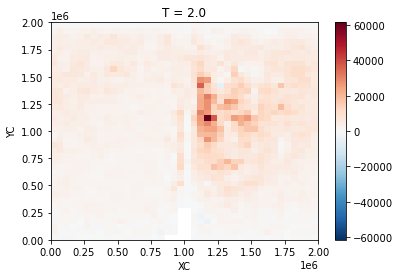

In [23]:
Ktensor_fast.isel(i=1, j=1).sel(T=2, method='nearest').plot()

In [ ]:
K = xr.DataArray(np.ones((len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))),
                          len(dsz.XC),1,2,2))*np.nan,
                 dims=['YC','XC','sig','col','row'],
                 coords={'YC':dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).data,
                         'XC':dsz.XC.data,'sig':np.array([dsz.sig.isel(sig=l)])}
                )
for j in range(len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)))):
    if j % 40 == 0:
        print('j =', j)
    for i in range(len(dsz.XC)):
#         if i < len(dsz.XC)-1:
#             k = i+1
#         else:
#             k = 0
#         rowF  = np.array([ 0, 0, 
#                            1, 1,
#                            2, 2,
#                            3, 3, 
#                            4, 4,
#                            5, 5,
#                            6, 6, 
#                            7, 7,
#                            8, 8,
#                            9, 9,
#                           10,10,
#                           11,11,
#                           12,12,
#                           13,13,
#                           14,14])
#         colF  = np.array([ 0, 1, 
#                            0, 1, 
#                            0, 1,
#                            0, 1, 
#                            0, 1, 
#                            0, 1,
#                            0, 1, 
#                            0, 1, 
#                            0, 1,
#                            0, 1, 
#                            0, 1, 
#                            0, 1,
#                            0, 1, 
#                            0, 1, 
#                            0, 1])
        dataF = np.array([ 
#                            ut_norm.isel(YC=j-1,XC=i),  vt_norm.isel(YC=j-1,XC=i),
#                            us_norm.isel(YC=j-1,XC=i),  vs_norm.isel(YC=j-1,XC=i),
#                           uPV_norm.isel(YC=j-1,XC=i), vPV_norm.isel(YC=j-1,XC=i),
                          [ ut_norm.isel(YC=j,XC=i),    vt_norm.isel(YC=j,XC=i)],
                          [ us_norm.isel(YC=j,XC=i),    vs_norm.isel(YC=j,XC=i)],
                          [uPV_norm.isel(YC=j,XC=i),   vPV_norm.isel(YC=j,XC=i)],
#                            ut_norm.isel(YC=j+1,XC=i),  vt_norm.isel(YC=j+1,XC=i),
#                            us_norm.isel(YC=j+1,XC=i),  vs_norm.isel(YC=j+1,XC=i),
#                           uPV_norm.isel(YC=j+1,XC=i), vPV_norm.isel(YC=j+1,XC=i),
#                            ut_norm.isel(YC=j,XC=i-1),  vt_norm.isel(YC=j,XC=i-1),
#                            us_norm.isel(YC=j,XC=i-1),  vs_norm.isel(YC=j,XC=i-1),
#                           uPV_norm.isel(YC=j,XC=i-1), vPV_norm.isel(YC=j,XC=i-1),
#                            ut_norm.isel(YC=j,XC=k),    vt_norm.isel(YC=j,XC=k),
#                            us_norm.isel(YC=j,XC=k),    vs_norm.isel(YC=j,XC=k),
#                           uPV_norm.isel(YC=j,XC=k),   vPV_norm.isel(YC=j,XC=k)
                         ])
#         F = spar.csr_matrix((dataF, (rowF, colF)), shape=(3,2)).toarray()
        F = dataF
##########################
#         rowG  = np.array([ 0, 0, 1, 1, 2, 2,
#                            3, 3, 4, 4, 5, 5,
#                            6, 6, 7, 7, 8, 8,
#                            9, 9,10,10,11,11,
#                           12,12,13,13,14,14,
#                           15,15,15, 
#                           16,16,16,
#                           17,17,17, 
#                           18,18,18,
#                           19,19,19, 
#                           20,20,20,
#                           21,21,21, 
#                           22,22,22
#                          ])
#         colG  = np.array([ 0, 3, 0, 3, 0, 3,
#                            1, 4, 1, 4, 1, 4,
#                            2, 5, 2, 5, 2, 5,
#                            6, 8, 6, 8, 6, 8,
#                            7, 9, 7, 9, 7, 9,
#                            0, 1, 2,    # A
#                            3, 4, 5,    # A
#                            6, 1, 7,    # B
#                            8, 4, 9,    # B
#                            0, 1, 2,    # A
#                            3, 4, 5,    # A
#                            6, 1, 7,    # B
#                            8, 4, 9])   # B
#         wht = 1e3   # 1e6*1e-4
#         Aj_1i = wht*(dyU.isel(YC=j,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
#         Aji = wht*-dyT.isel(YC=j+1,XC=i)**-1*(dyU.isel(YC=j+1,XG=i)**-1
#                                               + dyU.isel(YC=j,XG=i)**-1
#                                              )
#         Aj1i = wht*(dyU.isel(YC=j+1,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
#         Bji_1 = wht*(dxV.isel(YG=j,XC=i)*dxT.isel(YC=j,XC=k))**-1
#         Bji = wht*-dxT.isel(YC=j,XC=k)**-1*(dxV.isel(YG=j,XC=k)**-1
#                                             + dxV.isel(YG=j,XC=i)**-1
#                                            )
#         Bji1 = wht*(dxV.isel(YG=j,XC=k)*dxT.isel(YC=j,XC=k))**-1
        dataG = np.array([ 
#                            -tx_norm.isel(YC=j-1,XC=i),  -ty_norm.isel(YC=j-1,XC=i),
#                            -sx_norm.isel(YC=j-1,XC=i),  -sy_norm.isel(YC=j-1,XC=i),
#                           -PVx_norm.isel(YC=j-1,XC=i), -PVy_norm.isel(YC=j-1,XC=i),
                          [ -tx_norm.isel(YC=j,XC=i),    -ty_norm.isel(YC=j,XC=i)],
                          [ -sx_norm.isel(YC=j,XC=i),    -sy_norm.isel(YC=j,XC=i)],
                          [-PVx_norm.isel(YC=j,XC=i),   -PVy_norm.isel(YC=j,XC=i)],
#                            -tx_norm.isel(YC=j+1,XC=i),  -ty_norm.isel(YC=j+1,XC=i),
#                            -sx_norm.isel(YC=j+1,XC=i),  -sy_norm.isel(YC=j+1,XC=i),
#                           -PVx_norm.isel(YC=j+1,XC=i), -PVy_norm.isel(YC=j+1,XC=i),
#                            -tx_norm.isel(YC=j,XC=i-1),  -ty_norm.isel(YC=j,XC=i-1),
#                            -sx_norm.isel(YC=j,XC=i-1),  -sy_norm.isel(YC=j,XC=i-1),
#                           -PVx_norm.isel(YC=j,XC=i-1), -PVy_norm.isel(YC=j,XC=i-1),
#                            -tx_norm.isel(YC=j,XC=k),    -ty_norm.isel(YC=j,XC=k),
#                            -sx_norm.isel(YC=j,XC=k),    -sy_norm.isel(YC=j,XC=k),
#                           -PVx_norm.isel(YC=j,XC=k),   -PVy_norm.isel(YC=j,XC=k),
    ################################                          
#                            Aj_1i, Aji, Aj1i,
#                            Aj_1i, Aji, Aj1i,
#                            Bji_1, Bji, Bji1,
#                            Bji_1, Bji, Bji1,
    ################################
#                            Aj_1i, Aji, Aj1i,
#                            Aj_1i, Aji, Aj1i,
#                            Bji_1, Bji, Bji1,
#                            Bji_1, Bji, Bji1
                          ])
#         G = spar.csr_matrix((dataG, (rowG, colG)), shape=(3,2)).toarray()
        G = dataG
#############################
        if ~(np.isnan(F).any() or np.isnan(G).any()):
    #             try:
    #             tmp = np.linalg.inv(np.transpose(G).dot(G)).dot(np.transpose(G)).dot(F)
    #             K.isel(YC=j,XC=i)[0,0] = tmp[1,0]
    #             K.isel(YC=j,XC=i)[1,0] = tmp[4,0]
    #             K.isel(YC=j,XC=i)[0,1] = tmp[1,2]
    #             K.isel(YC=j,XC=i)[1,1] = tmp[4,2]
#                 GT = np.transpose(G)
#                 K.isel(YC=j,XC=i,sig=k)[:] = np.linalg.inv(GT.dot(G)).dot(GT).dot(F)
#             tmp = np.linalg.pinv(G).dot(F)
#             K.isel(YC=j,XC=i,sig=0)[0,0] = tmp[1,0]
#             K.isel(YC=j,XC=i,sig=0)[1,0] = tmp[4,0]
#             K.isel(YC=j,XC=i,sig=0)[0,1] = tmp[1,1]
#             K.isel(YC=j,XC=i,sig=0)[1,1] = tmp[4,1]
#             try:
#                 K.isel(YC=j,XC=i,sig=0)[:] = np.linalg.inv(G).dot(F)
#             except:
            K.isel(YC=j,XC=i,sig=0)[:] = np.linalg.pinv(G).dot(F)
itime = 943920
K.to_dataset(name='K').to_netcdf(op.join(ddir,
                                    '%4d/Diff-tensor_adjusted_isig16_%010d_Hann_no-smoothness.nc' 
                                         % (year,itime)))
# K = xr.open_dataset(op.join(ddir,'%4d/Diff-tensor_isig16_%010d.nc' 
#                             % (year,itime))).K
K